In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# Load the single Titanic CSV
df = pd.read_csv('titanic.csv')   # your single CSV file
df.shape
df.head()
df.info()
df.describe(include='all').T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
PassengerId,891.0,NaN,NaN,NaN,446.0,257.353842,1.0,223.5,446.0,668.5,891.0
Survived,891.0,NaN,NaN,NaN,0.383838,0.486592,0.0,0.0,0.0,1.0,1.0
Pclass,891.0,NaN,NaN,NaN,2.308642,0.836071,1.0,2.0,3.0,3.0,3.0
Name,891,891,"Braund, Mr. Owen Harris",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex,891,2,male,577,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,714.0,NaN,NaN,NaN,29.699118,14.526497,0.42,20.125,28.0,38.0,80.0
SibSp,891.0,NaN,NaN,NaN,0.523008,1.102743,0.0,0.0,0.0,1.0,8.0
Parch,891.0,NaN,NaN,NaN,0.381594,0.806057,0.0,0.0,0.0,0.0,6.0
Ticket,891,681,347082,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fare,891.0,NaN,NaN,NaN,32.204208,49.693429,0.0,7.9104,14.4542,31.0,512.3292


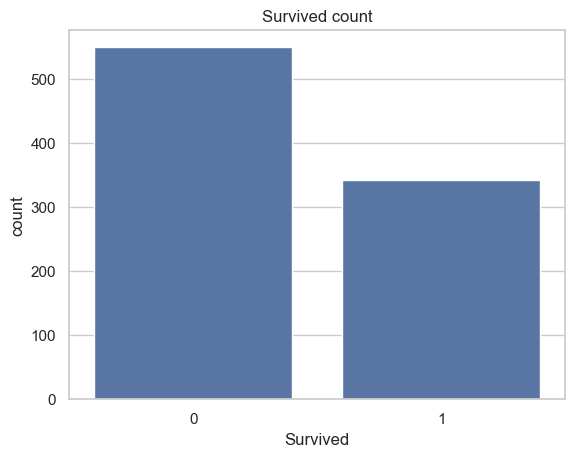

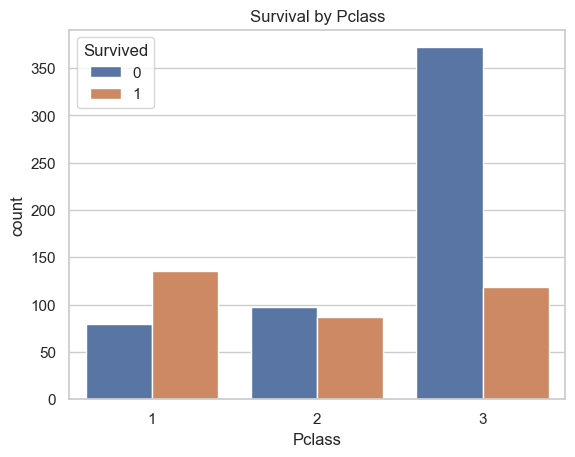

In [5]:
missing = df.isnull().sum().sort_values(ascending=False)
missing = pd.concat([missing, (df.isnull().mean()*100).sort_values(ascending=False)], axis=1)
missing.columns = ['missing_count', 'missing_pct']
missing.head(10)

# Target distribution
sns.countplot(x='Survived', data=df)
plt.title('Survived count')
plt.show()

# Pclass vs Survived
sns.countplot(x='Pclass', hue='Survived', data=df)
plt.title('Survival by Pclass')
plt.show()

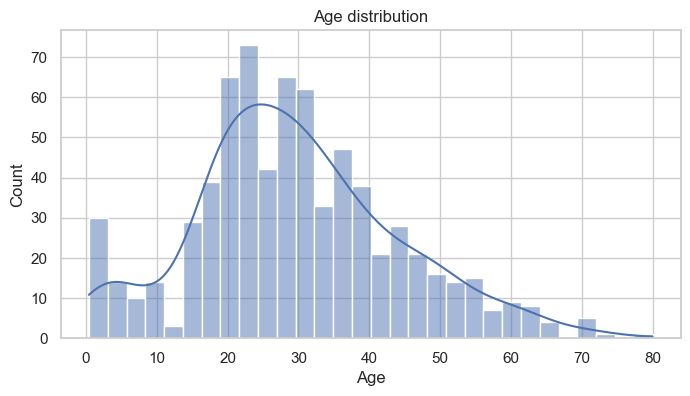

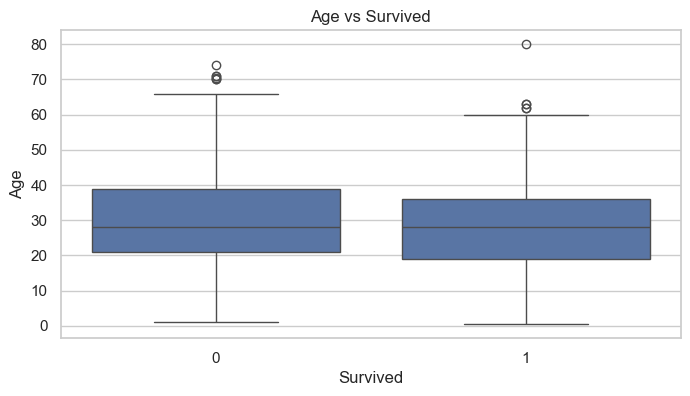

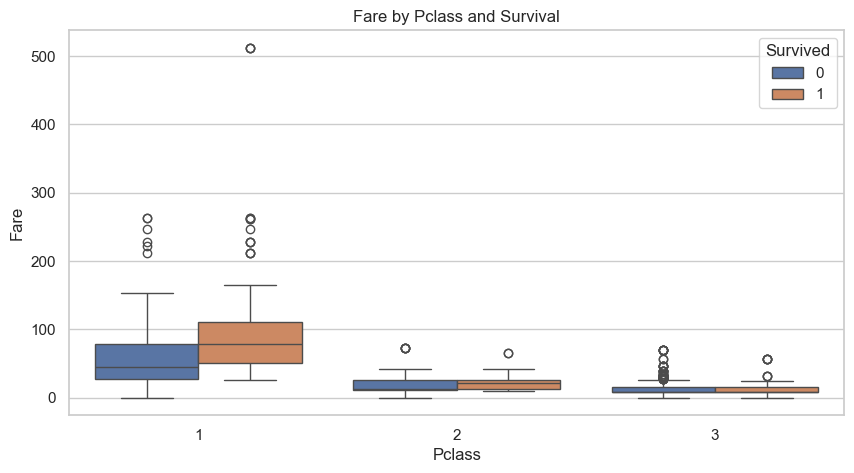

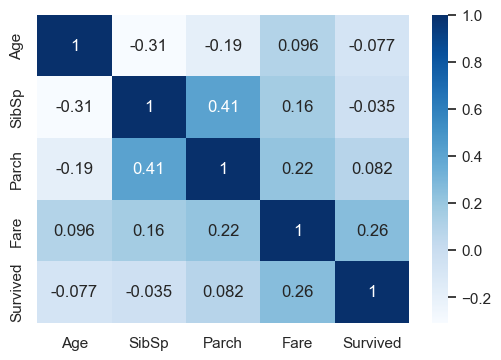

In [7]:
plt.figure(figsize=(8,4))
sns.histplot(df['Age'].dropna(), kde=True, bins=30)
plt.title('Age distribution')
plt.show()

# Age vs Survival (boxplot)
plt.figure(figsize=(8,4))
sns.boxplot(x='Survived', y='Age', data=df)
plt.title('Age vs Survived')
plt.show()

# Fare distribution by class & survival
plt.figure(figsize=(10,5))
sns.boxplot(x='Pclass', y='Fare', hue='Survived', data=df)
plt.title('Fare by Pclass and Survival')
plt.show()

# Correlation heatmap for numeric cols
num_cols = ['Age','SibSp','Parch','Fare','Survived']
plt.figure(figsize=(6,4))
sns.heatmap(df[num_cols].corr(), annot=True, cmap='Blues')
plt.show()

In [21]:
df['Title'] = df['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)
df['Title'] = df['Title'].replace(['Mlle','Ms','Mme'],'Miss')  # small cleanup

# Family size
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

# Cabin: take first letter
df['CabinLetter'] = df['Cabin'].str[0]
df['CabinLetter'] = df['CabinLetter'].fillna('Unknown')

# Age bin
df['AgeBin'] = pd.cut(df['Age'], bins=[0,12,20,40,60,100], labels=['Child','Teen','Adult','MidAge','Senior'])

# Fill missing values
df['Embarked'].fillna(df['Embarked'].mode()[0])
df['Fare'].fillna(df['Fare'].median())
df['Age'] = df.groupby('Title')['Age'].transform(lambda x: x.fillna(x.median()))
df['Age'].fillna(df['Age'].median())  # final fallback

# ML pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# select features
features = ['Pclass','Sex','Age','Fare','Embarked','FamilySize','IsAlone','Title']
X = df[features]
y = df['Survived']
from sklearn.preprocessing import StandardScaler
# simple pipeline
numeric_features = ['Age','Fare','FamilySize']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),('scaler',StandardScaler())
])

categorical_features = ['Pclass','Sex','Embarked','Title','IsAlone']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(max_iter=1000,solver='lbfgs'))])


CV accuracy: 0.823096621688171 [0.79020979 0.81118881 0.85915493 0.83098592 0.82394366]
Validation Accuracy: 0.8379888268156425
              precision    recall  f1-score   support

           0       0.86      0.88      0.87       110
           1       0.80      0.77      0.79        69

    accuracy                           0.84       179
   macro avg       0.83      0.82      0.83       179
weighted avg       0.84      0.84      0.84       179



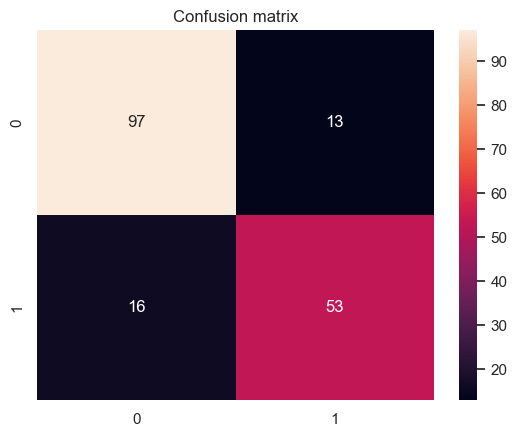

In [23]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Evaluate with cross-validation
scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
print("CV accuracy:", scores.mean(), scores)

# Train and predict
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)

print("Validation Accuracy:", accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt='d')
plt.title('Confusion matrix')
plt.show()